## Attention Only Classification Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import keras
from keras import backend as K
import tensorflow as tf

import os
import numpy as np
import pandas as pd
import scipy

import Bio
from Bio import SeqIO
import Bio.motifs

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import model_selection
import sklearn

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from signal_models import *
from utility_functions import *

sns.set_context('notebook')

Using TensorFlow backend.


In [2]:
working_directory = '/home/jtao/analysis/genomic_grammar_analysis/'

## Set Model Settings

In [91]:
### settings for attention model ###
attention_num_motifs=150
attention_motif_size=10
adjacent_bp_pool_size=10
attention_dropout_rate=0.1

### settings for convolution model ###
convolution_num_motifs=16
convolution_motif_size=24
num_dense_neurons=32
convolution_dropout_rate=0.5

largeConvolution_num_motifs = 100
large_num_dense_neurons = 32

## Read Data

In [366]:
treatment_positive_fasta_dict = {}
treatment_negative_fasta_dict = {}
treatment_positive_seqArray_dict = {}
treatment_positive_rc_seqArray_dict = {}
treatment_negative_seqArray_dict = {}
treatment_negative_rc_seqArray_dict = {}

for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]
    
    positive_fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]
    negative_fasta_seq = [str(x.seq[:200]) for x in negative_seqRecords]
    
    positive_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords]
    negative_rc_fasta_seq = [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]
    
    positive_sequence_arrays = convert_sequences_to_array(positive_fasta_seq)
    positive_rc_sequence_arrays = convert_sequences_to_array(positive_rc_fasta_seq)
    
    negative_sequence_arrays = convert_sequences_to_array(negative_fasta_seq)
    negative_rc_sequence_arrays = convert_sequences_to_array(negative_rc_fasta_seq)
    
    treatment_positive_fasta_dict[treatment] = positive_fasta_seq
    treatment_negative_fasta_dict[treatment] = negative_fasta_seq
    treatment_positive_seqArray_dict[treatment] = positive_sequence_arrays
    treatment_positive_rc_seqArray_dict[treatment] = positive_rc_sequence_arrays
    treatment_negative_seqArray_dict[treatment] = negative_sequence_arrays
    treatment_negative_rc_seqArray_dict[treatment] = negative_rc_sequence_arrays

*** kla-1h ***
*** veh ***
*** il4-24h ***


## Train All Models for all Data Sets

In [369]:
positive_sequence_arrays.shape

(33518, 200, 4)

In [370]:
negative_sequence_arrays.shape

(33518, 200, 4)

In [371]:
.shape

(67036, 200, 4)

In [ ]:
num_epochs = 30
all_rocs = []
all_accuracies = []
all_precisions = []
all_treatments = []
model_types = []
parameter_counts = []
train_addAttention = False
train_dotAttention = True
train_convolution = False
train_large_convolution = False

# condition_model_dict = {}
for treatment in treatment_positive_fasta_dict:
    positive_sequence_arrays = treatment_positive_seqArray_dict[treatment] 
    positive_rc_sequence_arrays = treatment_positive_rc_seqArray_dict[treatment]
    negative_sequence_arrays = treatment_negative_seqArray_dict[treatment]
    negative_rc_sequence_arrays = treatment_negative_rc_seqArray_dict[treatment]

    sequence_arrays = np.concatenate([positive_sequence_arrays, negative_sequence_arrays])
    sequence_rc_arrays = np.concatenate([positive_rc_sequence_arrays, negative_rc_sequence_arrays])
    labels = [1 for x in positive_sequence_arrays] + [0 for x in negative_sequence_arrays]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(
        sequence_arrays, 
        sequence_rc_arrays, 
        labels, 
        test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
       
    ### additive attention model ###
#     print('Training AddAttention', treatment)
#     additiveAttention_model = get_additiveAttention_model(200,
#         mode='classification',
#         num_motifs=150, 
#         motif_size=10,
#         adjacent_bp_pool_size=10,
#         attention_dim=10,
#         attention_hops=10,
#         dropout_rate=0.1
#     )
        
#     additiveAttention_model.fit([x_train], y_train,
#               batch_size=64,
#               epochs=num_epochs,
#               verbose=1,
#               validation_data=([x_test], y_test))

#     probs = additiveAttention_model.predict([x_test])
#     test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
#     roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
#     precision = sklearn.metrics.precision_score([y[1] for y in y_test], test_predictions)
#     acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
#     param_count = additiveAttention_model.count_params()
# 
#     all_rocs.append(roc)
#     all_accuracies.append(acc)
#     all_precisions.append(precision)
#     all_treatments.append(treatment)
#     model_types.append('AddAttention')
#     parameter_counts.append(param_count)
#     condition_model_dict['AddAttention_'+treatment] = additiveAttention_model
    ### ###
    
    ### dot product attention model ###
    if train_dotAttention:
        print('Training DotAttention', treatment)
        dotProductAttention_model = get_dotProductAttention_model(200,
            mode='classification',
            num_motifs=attention_num_motifs, 
            motif_size=attention_motif_size,
            adjacent_bp_pool_size=adjacent_bp_pool_size,
            dropout_rate=attention_dropout_rate,
            num_classes=2)

        dotProductAttention_model.fit([x_train], y_train,
                  batch_size=64,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=([x_test], y_test))

        probs = dotProductAttention_model.predict([x_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        param_count = dotProductAttention_model.count_params()

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        all_treatments.append(treatment)
        model_types.append('DotAttention')
        parameter_counts.append(param_count)
        condition_model_dict['DotAttention_'+treatment] = dotProductAttention_model
    ### ###

    ### convolution model ###
    if train_convolution:
        print('Training Convolution', treatment)
        convolution_model = get_convolution_model(200,
            mode='classification',
            num_motifs=convolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
        convolution_model.fit([x_train, x_rc_train], y_train,
                  batch_size=64,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=([x_test, x_rc_test], y_test))

        probs = convolution_model.predict([x_test, x_rc_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        param_count = convolution_model.count_params()

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        all_treatments.append(treatment)
        model_types.append('Convolution')
        parameter_counts.append(param_count)
        condition_model_dict['Convolution_'+treatment] = convolution_model
    
    ### large convolution model ###
    if train_large_convolution:
        print('Training Large Convolution', treatment)
        large_convolution_model = get_convolution_model(200,
            mode='classification',
            num_motifs=largeConvolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=large_num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
        large_convolution_model.fit([x_train, x_rc_train], y_train,
                  batch_size=64,
                  epochs=num_epochs,
                  verbose=1,
                  validation_data=([x_test, x_rc_test], y_test))

        probs = large_convolution_model.predict([x_test, x_rc_test])
        test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
        roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
        precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
        acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
        param_count = convolution_model.count_params()

        all_rocs.append(roc)
        all_accuracies.append(acc)
        all_precisions.append(precision)
        all_treatments.append(treatment)
        model_types.append('LargeConvolution')
        parameter_counts.append(param_count)
        condition_model_dict['LargeConvolution_'+treatment] = large_convolution_model

Training DotAttention veh
1 1
Train on 50480 samples, validate on 12620 samples
Epoch 1/30
50480/50480 [==============================] - 15s 296us/step - loss: 0.6189 - categorical_accuracy: 0.6428 - val_loss: 0.5263 - val_categorical_accuracy: 0.7418
Epoch 2/30
50480/50480 [==============================] - 13s 250us/step - loss: 0.4970 - categorical_accuracy: 0.7591 - val_loss: 0.4746 - val_categorical_accuracy: 0.7687
Epoch 3/30
50480/50480 [==============================] - 13s 253us/step - loss: 0.4455 - categorical_accuracy: 0.7926 - val_loss: 0.4379 - val_categorical_accuracy: 0.7996
Epoch 4/30
50480/50480 [==============================] - 12s 247us/step - loss: 0.4152 - categorical_accuracy: 0.8108 - val_loss: 0.4096 - val_categorical_accuracy: 0.8147
Epoch 5/30
50480/50480 [==============================] - 13s 249us/step - loss: 0.3965 - categorical_accuracy: 0.8214 - val_loss: 0.4172 - val_categorical_accuracy: 0.8083
Epoch 6/30
50480/50480 [==============================]

## Serialize Models

In [94]:
if len(condition_model_dict) > 0:
    if not os.path.isdir(working_directory + '/models_classification'):
        os.mkdir(working_directory + '/models_classification')
    else:
        for f in os.listdir(working_directory + '/models_classification'):
            os.remove(working_directory + '/models_classification/' + f)
    for treatment_modelType in condition_model_dict.keys():
        current_model = condition_model_dict[treatment_modelType]
        current_model.save_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5',
                          )

## Read in Models

In [80]:
condition_model_dict = {}
for f in os.listdir(working_directory + '/models_classification/'):
    treatment_modelType = f.replace('_weights.h5','')
    modelType = treatment_modelType.split('_')[0]    
    if modelType == 'DotAttention':
        current_model = get_dotProductAttention_model(200,
            mode='classification',
            num_motifs=attention_num_motifs, 
            motif_size=attention_motif_size,
            adjacent_bp_pool_size=adjacent_bp_pool_size,
            dropout_rate=attention_dropout_rate,
            num_classes=2)  
    elif modelType == 'Convolution':
        current_model = get_convolution_model(200,
            mode='classification',
            num_motifs=convolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
    elif modelType == 'LargeConvolution':
        current_model = get_convolution_model(200,
            mode='classification',
            num_motifs= largeConvolution_num_motifs, 
            motif_size=convolution_motif_size,
            num_dense_neurons=large_num_dense_neurons,
            dropout_rate=convolution_dropout_rate,
            num_classes=2)
    current_model.load_weights(working_directory + '/models_classification/' + treatment_modelType + '_weights.h5',
                              )
    condition_model_dict[treatment_modelType] = current_model

## Test Model Performance

In [95]:
all_rocs = []
all_accuracies = []
all_precisions = []
all_treatments = []
model_types = []
parameter_counts = []
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    for treatment_model in condition_model_dict.keys():      
        if treatment_model.split('_')[1] == treatment:
            current_model = condition_model_dict[treatment_model] 
            if treatment_model.split('_')[0] == 'Convolution':
                probs = current_model.predict([x_test, x_rc_test])
                test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
                precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
                acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                param_count = convolution_model.count_params()
                model_types.append('Convolution')
            elif treatment_model.split('_')[0] == 'LargeConvolution':
                probs = current_model.predict([x_test, x_rc_test])
                test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
                precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
                acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                param_count = convolution_model.count_params()
                model_types.append('LargeConvolution')
            elif treatment_model.split('_')[0] == 'DotAttention':
                probs = current_model.predict([x_test])
                test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1], )
                precision = sklearn.metrics.precision_score([y[1] for y in y_test], [0 if x[0] > x[1] else 1 for x in probs])
                acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                param_count = current_model.count_params()
                model_types.append('DotAttention')
            else:
                print('moo', treatment_model)
            
            
            all_rocs.append(roc)
            all_accuracies.append(acc)
            all_precisions.append(precision)
            all_treatments.append(treatment)
            
            parameter_counts.append(param_count)
            print(treatment_model, acc, roc, precision)

*** kla-1h ***
Convolution_kla-1h 0.8598323958213753 0.9287874232131801 0.8394366197183099
DotAttention_kla-1h 0.9073585122259212 0.9589725887380842 0.890380805635043
LargeConvolution_kla-1h 0.908850878199977 0.9753556834766286 0.8575733226195259
*** veh ***
DotAttention_veh 0.8991283676703645 0.936092542258519 0.8883116883116883
LargeConvolution_veh 0.8972266244057052 0.9689080600424212 0.8508808433902066
Convolution_veh 0.8446909667194928 0.9199942537777682 0.8186430849521601
*** il4-24h ***
DotAttention_il4-24h 0.8960322195704057 0.94802465290424 0.8906389301634473
Convolution_il4-24h 0.8522523866348448 0.9264891086322413 0.819450143619204
LargeConvolution_il4-24h 0.9166915274463007 0.9717985028875247 0.9143584368917502


In [96]:
performance_frame = pd.DataFrame({'Model Type': model_types, 
                                  'Treatment':all_treatments,
                                  'Accuracy':all_accuracies, 
                                  'aucROC':all_rocs,
                                  'Precision':all_precisions})

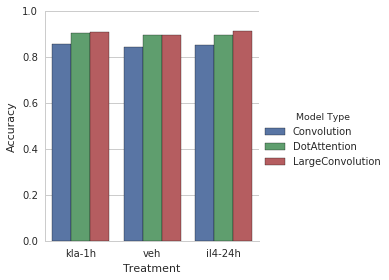

In [97]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Accuracy',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

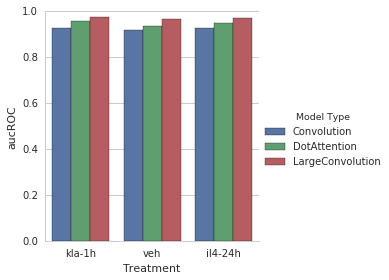

In [98]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'aucROC',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

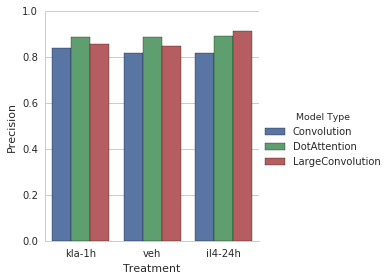

In [99]:
with sns.axes_style('whitegrid'):
    sns.factorplot(data = performance_frame,
        x = 'Treatment', 
        y = 'Precision',
        hue = 'Model Type',
        kind = 'bar'
        )
    plt.ylim(0,1)

## Grid Search for Dot Product Attention Model

In [ ]:
all_rocs = []
all_accuracies = []
all_precisions = []
poolSize_list = []
all_treatments = []
motifCount_list = []
numDense_list = []
paramCount_list = []
dropoutRate_list = []
num_epochs = 20
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    print(ps)
    positive_seqRecords = list(SeqIO.parse(working_directory + '/peak_sequences/' + ps, 'fasta'))
    negative_seqRecords = list(SeqIO.parse(working_directory + '/background_files/' + ps.replace('_peaks', '_background'), 'fasta'))[:len(positive_seqRecords)]

    fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords] + [str(x[:200].seq) for x in negative_seqRecords]

    fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords] + \
        [str(x[:200].reverse_complement().seq) for x in negative_seqRecords]

    sequence_arrays = convert_sequences_to_array(fasta_seq)

    sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)


    labels = [1 for x in positive_seqRecords] + [0 for x in negative_seqRecords]
    labels = np.array(labels)

    x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)

    num_classes = 2
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    treatment = ps.split('_')[1]
    
    for d in range(50,200,50):
        for m in range(50,200,50):
            for p in [5,10,20]:
                for do in [0.25,0.5,0.75]:
                    
                    current_model = get_dotProductAttention_model(200,
                        mode='classification',
                        num_classes = 2,
                        num_motifs=m, 
                        motif_size=10,
                        adjacent_bp_pool_size=p,
                        num_dense_neurons=d,
                        dropout_rate=do)
                    num_params = current_model.count_params()
                    print(treatment, 
                         'num dense', d,
                         'num motifs', m,
                         'pool size', p,
                         'dropout rate', do,
                         'param count', num_params)
                    current_model.fit(x_train, y_train,
                          batch_size=64,
                          epochs=num_epochs,
                          verbose=1,
                          validation_data=([x_test], y_test))

                    probs = current_model.predict([x_test])
                    test_predictions = [0 if x[0] > x[1] else 1 for x in probs]
                    roc = sklearn.metrics.roc_auc_score([y[1] for y in y_test], probs[:,1])
                    precision = sklearn.metrics.precision_score([y[1] for y in y_test], test_predictions)
                    acc = sklearn.metrics.accuracy_score([y[1] for y in y_test], test_predictions)
                    
                    all_rocs.append(roc)
                    all_accuracies.append(acc)
                    all_precisions.append(precision)
                    poolSize_list.append(p)
                    all_treatments.append(treatment)
                    motifCount_list.append(m)
                    numDense_list.append(d)
                    paramCount_list.append(num_params)
                    dropoutRate_list.append(do)

In [21]:
performance_frame = pd.DataFrame({'aucROC':all_rocs, 
                      'Accuracy':all_accuracies, 
                      'Pool Size':poolSize_list, 
                      'Precision':all_precisions,
                      'Treatment':all_treatments,
                      'Num Motifs':motifCount_list,
                      'Num Dense':numDense_list,
                      'Num Params':paramCount_list,
                      'Dropout Rate':dropoutRate_list
                      })

In [22]:
performance_frame.to_csv('./grid_search_results.tsv', sep='\t')

In [29]:
performance_frame[performance_frame['Treatment'] == 'kla-1h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
50,0.835725,0.75,100,150,40152,10,0.870618,kla-1h,0.920197
77,0.837447,0.75,150,150,56702,10,0.873728,kla-1h,0.916011
23,0.837791,0.75,50,150,23602,10,0.879173,kla-1h,0.915555
68,0.839972,0.75,150,100,39352,10,0.896112,kla-1h,0.915317
11,0.831133,0.75,50,100,17752,5,0.866940,kla-1h,0.914013


In [30]:
performance_frame[performance_frame['Treatment'] == 'il4-24h'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
185,0.853222,0.75,50,150,23602,10,0.885384,il4-24h,0.930444
209,0.848150,0.75,100,150,43152,5,0.851699,il4-24h,0.927972
200,0.842035,0.75,100,100,30802,5,0.912084,il4-24h,0.927763
212,0.829430,0.75,100,150,40152,10,0.818121,il4-24h,0.927611
239,0.847554,0.75,150,150,56702,10,0.849713,il4-24h,0.927164


In [31]:
performance_frame[performance_frame['Treatment'] == 'veh'].sort_values('aucROC',ascending = False).head()

,Accuracy,Dropout Rate,Num Dense,Num Motifs,Num Params,Pool Size,Precision,Treatment,aucROC
104,0.854675,0.75,50,150,23602,10,0.885764,veh,0.928435
158,0.853645,0.75,150,150,56702,10,0.880882,veh,0.926461
157,0.843978,0.50,150,150,56702,10,0.887498,veh,0.924575
155,0.848653,0.75,150,150,61202,5,0.884820,veh,0.923599
149,0.850634,0.75,150,100,39352,10,0.846551,veh,0.923239


(0.8, 0.9)

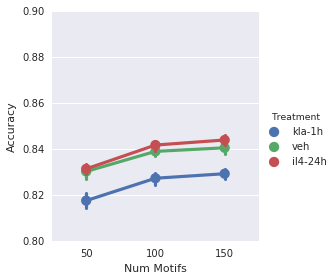

In [64]:
sns.factorplot(data = performance_frame, x = 'Num Motifs', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

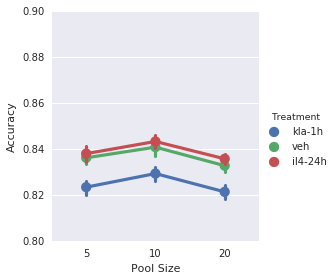

In [63]:
sns.factorplot(data = performance_frame, x = 'Pool Size', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

(0.8, 0.9)

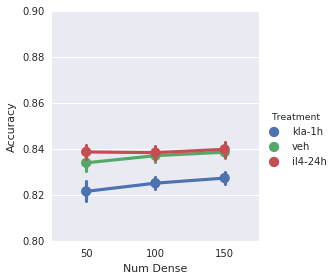

In [62]:
sns.factorplot(data = performance_frame, x = 'Num Dense', y='Accuracy', hue = 'Treatment')
plt.ylim(0.8,0.9)

## Weight Extraction

In [ ]:
treatment_attention_dict = {}
for ps in ['c57bl6_kla-1h_peaks.fasta', 'c57bl6_veh_peaks.fasta', 'c57bl6_il4-24h_peaks.fasta']:
    treatment = ps.split('_')[1]
    print('***',treatment, '***')
    fasta_seq = treatment_fasta_dict[treatment]
    
    sequence_arrays = treatment_positive_seqArray_dict[treatment]
    
    current_model = condition_model_dict['DotAttention_'+treatment]
    
    attention = get_sequence_attention(current_model,
        sequence_arrays,
        200,
        10)
    
    treatment_attention_dict[treatment] = attention


In [357]:
def get_sequence_attention(model, sequence_arrays, sequence_size, adjacent_bp_pool_size):
    get_attention = K.function([model.get_layer('input_fwd').input, 
                                K.learning_phase()
                               ], 
                               [model.get_layer('attending_layer').output])
    trimmed_sequences = [x[:sequence_size] for x in sequence_arrays]
    
    attention = get_attention((trimmed_sequences, 0))[0]

    return attention

## Visualize Attention

### Overall Matrix

In [ ]:
treatment_attention[0].shape

In [361]:
dotProductAttention_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 150)     6150        input_fwd[0][0]                  
__________________________________________________________________________________________________
sequence_pooling_layer (MaxPool (None, 20, 150)      0           convolution_layer[0][0]          
__________________________________________________________________________________________________
query_transformer (TimeDistribu (1, 20, 150)         150         sequence_pooling_layer[0][0]     
__________________________________________________________________________________________________
key_transf

In [360]:
treatment_attention.shape

(21776, 20, 150)

KeyboardInterrupt: 

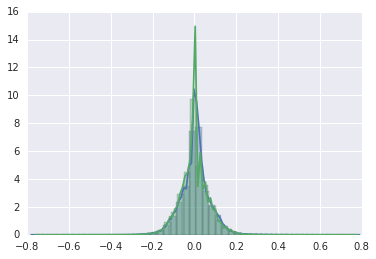

In [359]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    sns.distplot(treatment_attention.flatten(), label = treatment)
plt.xlabel('Attention')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [205]:
num_positions = 20
matrix_size = num_positions**2
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    print(treatment)
    for threshold in [np.round(x,2) for x in np.arange(0.1,1,0.05)]:
        for am in treatment_attention:
            count = np.sum(am.flatten() > threshold)
            count_list.append(count)
            normalized_count_list.append(count/matrix_size)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
        


veh
il4-24h
kla-1h


In [206]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list,
                      'Normalized Count':normalized_count_list})

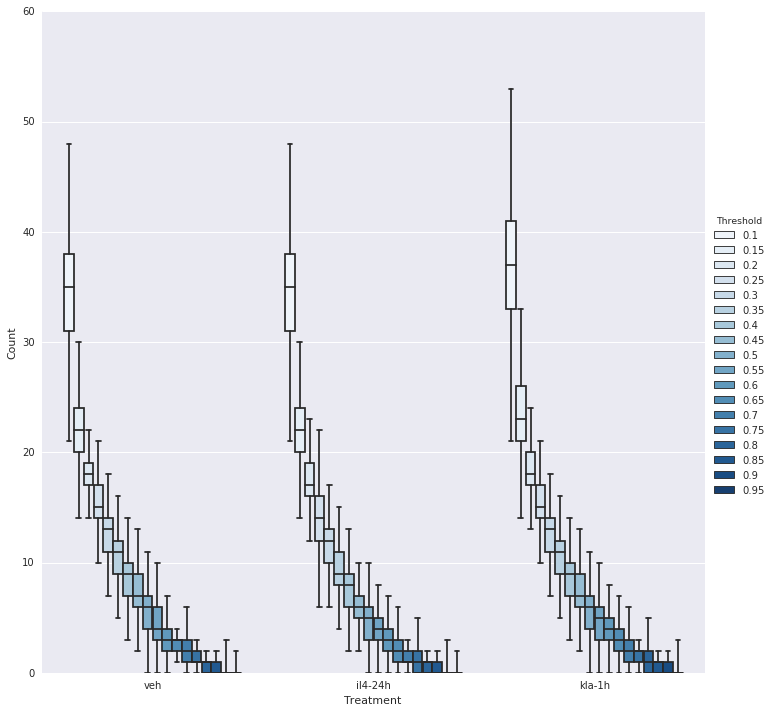

In [207]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Blues',
    showfliers=False,
    size = 10)

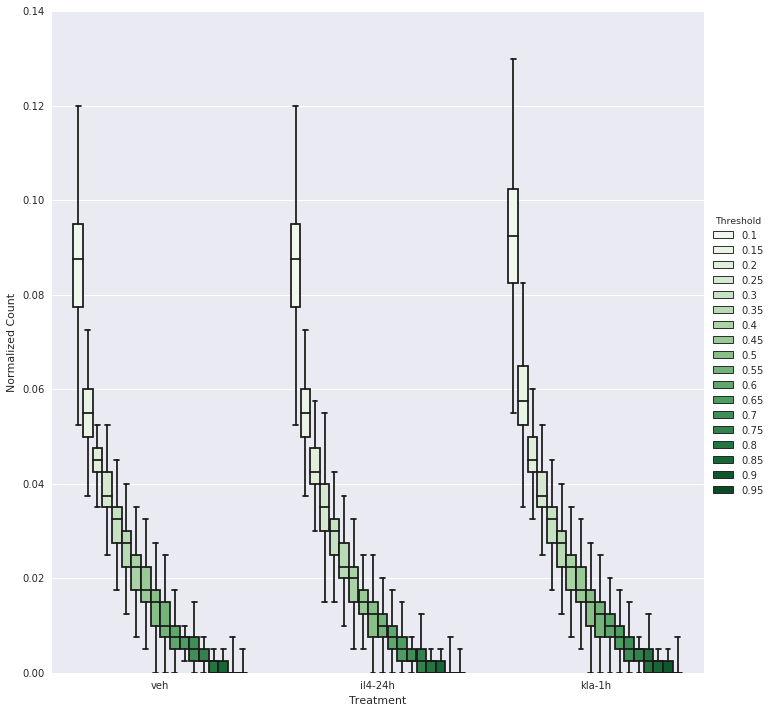

In [208]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Normalized Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Greens',
    showfliers=False,
    size = 10)

### Flattened Matrix 

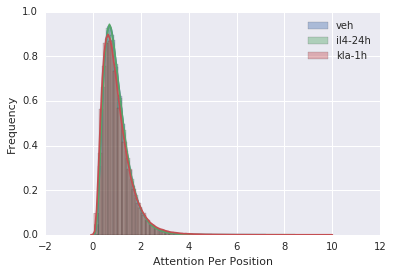

In [209]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    flattened_attention = np.array([x.sum(axis=1) for x in treatment_attention])
    sns.distplot(flattened_attention.flatten(), label = treatment)
plt.xlabel('Attention Per Position')
plt.ylabel('Frequency')
plt.legend()

#### Per sequence frequencies

In [313]:
num_positions = 20
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    flattened_attention = np.array([x.sum(axis=1) for x in treatment_attention])
    print(treatment)
    for threshold in [np.round(x,2) for x in np.arange(0.5,4,0.25)]:
        for fam in flattened_attention:
            count = np.sum(fam.flatten() >= threshold)
            count_list.append(count)
            normalized_count_list.append(count/num_positions)
            treatment_list.append(treatment)
            threshold_list.append(threshold)
        


veh
il4-24h
kla-1h


In [314]:
frame = pd.DataFrame({'Treatment': treatment_list, 
                      'Threshold': threshold_list,
                      'Count':count_list,
                      'Normalized Count':normalized_count_list})

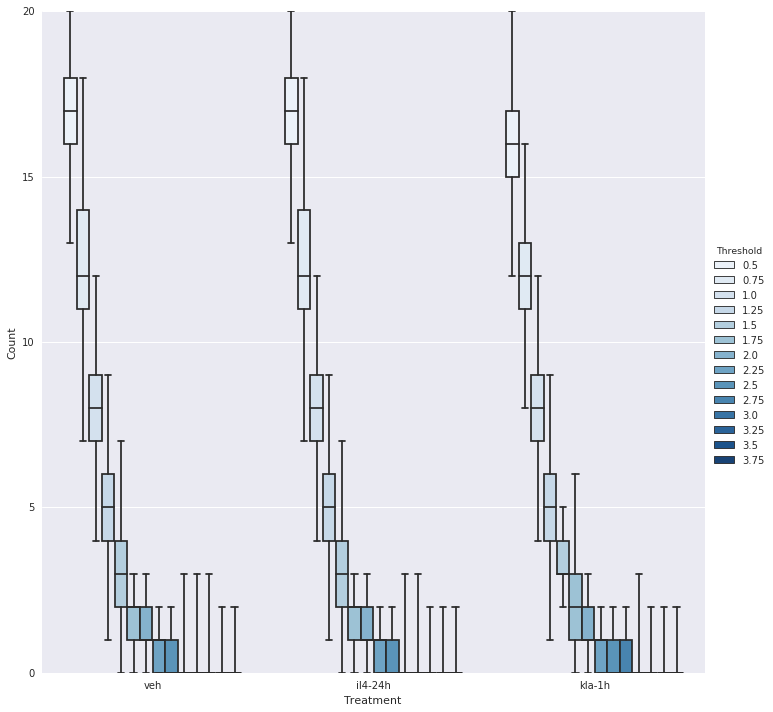

In [315]:
sns.factorplot(data = frame, 
    x = 'Treatment',
    y = 'Count',
    hue='Threshold',
    kind = 'box',
    palette = 'Blues',
    showfliers=False,
    size = 10)

#### Max Matrix

In [355]:
x = np.array([[1,2,3],[4,5,6]])

In [356]:
x

array([[1, 2, 3],
       [4, 5, 6]])

In [354]:
x.sum(axis=0)

array([12, 15, 18])

In [347]:
treatment_attention[0].sum(axis=0)

array([1.0000001 , 1.0000002 , 1.0000001 , 1.        , 0.99999976,
       1.        , 0.9999999 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 0.99999994, 1.        , 1.        , 1.        ],
      dtype=float32)

In [ ]:
for treatment in treatment_attention_dict:
    treatment_attention = treatment_attention_dict[treatment]
    flattened_attention = np.array([x.sum(axis=1) for x in treatment_attention])
#     sns.distplot(flattened_attention.flatten(), label = treatment)
# plt.xlabel('Attention Per Position')
# plt.ylabel('Frequency')
# plt.legend()

## Per k-mer attention analysis

### K-mers observed

In [213]:
print(4**10, '10-mers possible')

1048576 10-mers possible


In [216]:
kmer_size = 10
sequence_size = 200

for treatment in treatment_fasta_dict:
    kmer_set = set()
    print('***',treatment, '***')

    fasta_seq = treatment_fasta_dict[treatment]
    for seq in fasta_seq:
        for i in range(0,sequence_size-kmer_size):
            kmer = seq[i:i+kmer_size]
            kmer_set.add(kmer)
    print(len(kmer_set), '10-mers observed')   

*** veh ***
917179 10-mers observed
*** il4-24h ***
918403 10-mers observed
*** kla-1h ***
852757 10-mers observed


### Attention Accumulated by each 10-mer

#### Total

In [276]:
kmer_size = 10
sequence_size = 200
count_list = []
treatment_list = []
threshold_list = []
normalized_count_list = []
treatment_totalAttention_dict = {}
for treatment in treatment_attention_dict:
    kmer_totalAttention_dict = {}
    treatment_attention = treatment_attention_dict[treatment]
    flattened_attention = np.array([x.sum(axis=1) for x in treatment_attention])
    treatment_fasta = treatment_fasta_dict[treatment]
    for fam, seq in zip(flattened_attention, treatment_fasta):
        for i in range(0,sequence_size,kmer_size): 
            for j in range(kmer_size):
#                 print(i+j, i+j+kmer_size)
#                 print(len(subseq))
                subseq = seq[i+j: i+j+kmer_size]
                if not subseq in kmer_totalAttention_dict:
                    kmer_totalAttention_dict[subseq] = fam[int(i/kmer_size)]
                else:
                    kmer_totalAttention_dict[subseq] += fam[int(i/kmer_size)]
    treatment_totalAttention_dict[treatment] = kmer_totalAttention_dict

veh
kla-1h
il4-24h


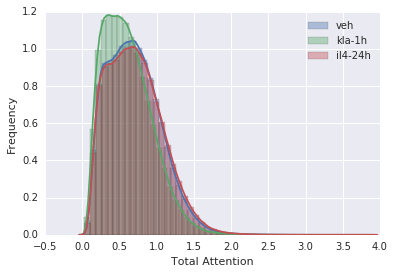

In [277]:
for treatment in treatment_kmerAttention_dict:
    print(treatment)
    totalAttention = np.array(list(treatment_kmerAttention_dict[treatment].values()))
    sns.distplot(np.log10(totalAttention+1), label = treatment)
plt.legend()
plt.xlabel('Total Attention')
plt.ylabel('Frequency')

#### Distribution

In [326]:
attention_threshold = 1.25
kmer_size = 10
sequence_size = 200
treatment_kmerAttendedCount_dict = {}
for treatment in treatment_attention_dict:
    kmer_attendedCount_dict = {}
    counter = 0
    treatment_attention = treatment_attention_dict[treatment]
    flattened_attention = np.array([x.sum(axis=1) for x in treatment_attention])
    treatment_fasta = treatment_fasta_dict[treatment]
    for fam, seq in zip(flattened_attention, treatment_fasta):
        for i in range(0,sequence_size,kmer_size): 
            for j in range(kmer_size):
                subseq = seq[i+j: i+j+kmer_size]
                att = fam[int(i/kmer_size)]
                if att >=attention_threshold:
                    counter +=1
                    if not subseq in kmer_attendedCount_dict:
                        kmer_attendedCount_dict[subseq] = 1
                    else:
                        kmer_attendedCount_dict[subseq] += 1
    print(treatment,counter)
    treatment_kmerAttendedCount_dict[treatment] = kmer_attendedCount_dict

veh 1610900
il4-24h 1721020
kla-1h 1120450


In [337]:
count_list = []
treatment_list = []
threshold_list = []
for treatment in treatment_kmerAttendedCount_dict:
    counts = np.array(list(treatment_kmerAttendedCount_dict[treatment].values()))
    fasta = treatment_fasta_dict[treatment]
    for threshold in np.arange(0.01,0.1,0.01):
        rounded_threshold = np.round(threshold, 3)
        count_threshold = int(threshold*len(fasta))
        count = np.sum(counts > count_threshold)
        
        count_list.append(count)
        treatment_list.append(treatment)
        threshold_list.append(rounded_threshold)
frame = pd.DataFrame({'Treatment':treatment_list,
                      'Threshold':threshold_list,
                      'Count':count_list})        

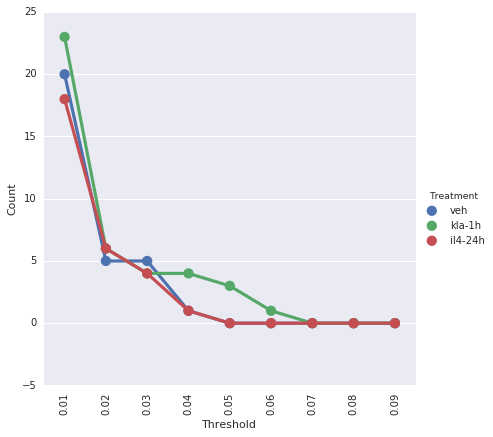

In [339]:
sns.factorplot(data = frame,
               x= 'Threshold',
               y = 'Count',
               hue = 'Treatment',
               size=6)
plt.xticks(rotation=90);